## Time Series

В данном ноутбуке в качестве данных будем использовать инфляцию, курс доллара, величину процентной ставки, а также лаговые переменные всех этих признаков и целевой переменной. Будем работать как с временным рядом, расчитаем лаговые признаки и попробуем в качестве классификатора Random Forest, KNN и CatBoost.

In [2]:
import os
import sys

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import optuna

# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics

In [3]:
# загружаем данные
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

### Lag Feature and Random Forest

Добавим лаговые признаки таргета с лагом от 1 до 5 включительно.

In [4]:
for i in range(1, 6):
    X[f"lag{i}_target"] = y.shift(i)

Проверим качество с помощью кросс-валидации

              precision    recall  f1-score   support

        -1.0       0.60      0.39      0.47        23
         0.0       0.41      0.50      0.45        26
         1.0       0.62      0.68      0.65        19

    accuracy                           0.51        68
   macro avg       0.54      0.53      0.52        68
weighted avg       0.53      0.51      0.51        68



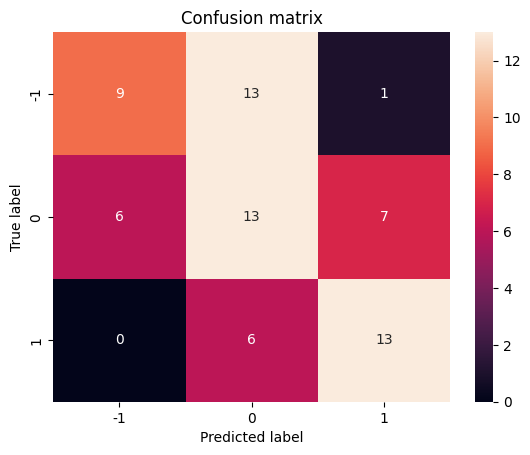

In [5]:
metrics, model = calc_metrics(
    X.filter(regex="target").values,  # обучаемся только на лаговых признаках
    y.values,
    RandomForestClassifier,
    name="lag target Random Forest",
    calc_jobs=-1,
    random_state=42,
)

In [6]:
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
lag target Random Forest,0.514706,0.523987,0.525172,0.541766,0.72933,0.736446


Попробуем добавить процентную ставку и четыре лаговых признака процентной ставки

In [7]:
for i in range(1, 5):
    X[f"lag{i}_rate"] = X["rate"].shift(i)

Взглянем на качество

              precision    recall  f1-score   support

        -1.0       0.62      0.57      0.59        23
         0.0       0.50      0.62      0.55        26
         1.0       0.80      0.63      0.71        19

    accuracy                           0.60        68
   macro avg       0.64      0.60      0.62        68
weighted avg       0.62      0.60      0.61        68



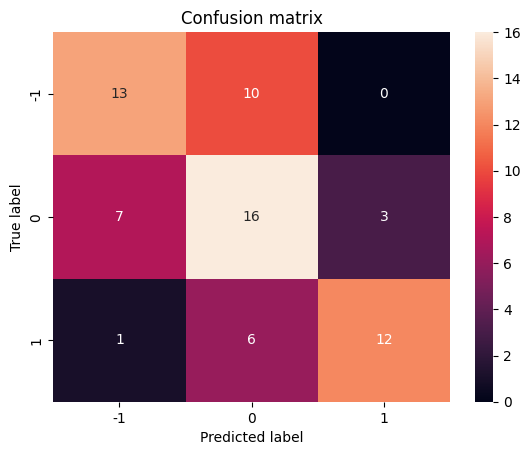

In [8]:
metric, model = calc_metrics(
    # отбираем колонки содержащие в названии target или rate
    X.filter(regex=r"(target)|(rate)").values,
    y.values,
    RandomForestClassifier,
    name="lag target, rate Random Forest",
    calc_jobs=-1,
    random_state=42,
)

In [9]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
lag target Random Forest,0.514706,0.523987,0.525172,0.541766,0.729330,0.736446
"lag target, rate Random Forest",0.602941,0.616172,0.604060,0.639683,0.733619,0.740583


Качество подросло, теперь попробуем добавить значение курса доллара и четыре его лаговых признака

In [10]:
for i in range(1, 5):
    X[f"lag{i}_usd"] = X["usd"].shift(i)

              precision    recall  f1-score   support

        -1.0       0.62      0.43      0.51        23
         0.0       0.47      0.69      0.56        26
         1.0       0.79      0.58      0.67        19

    accuracy                           0.57        68
   macro avg       0.63      0.57      0.58        68
weighted avg       0.61      0.57      0.57        68



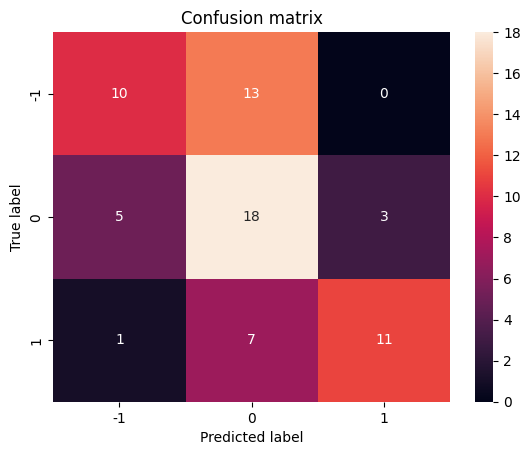

In [11]:
metric, model = calc_metrics(
    # отбираем необходимые признаки
    X.filter(regex=r"(target)|(rate)|(usd)").values,
    y.values,
    RandomForestClassifier,
    name="lag target, rate, usd Random Forest",
    calc_jobs=-1,
    random_state=42,
)

In [12]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
lag target Random Forest,0.514706,0.523987,0.525172,0.541766,0.729330,0.736446
"lag target, rate Random Forest",0.602941,0.616172,0.604060,0.639683,0.733619,0.740583
"lag target, rate, usd Random Forest",0.573529,0.580662,0.568679,0.628133,0.763321,0.769781


Наша основная метрика немно выросла, хотя accuracy, f1, recall и precision снизились. Если мы поиграемся с порогом то эти метрики тоже станут выше. Попробуем добавить инфляцию.

In [13]:
for i in range(1, 5):
    X[f"lag{i}_inflation"] = X["inflation"].shift(i)

              precision    recall  f1-score   support

        -1.0       0.82      0.61      0.70        23
         0.0       0.55      0.69      0.61        26
         1.0       0.72      0.68      0.70        19

    accuracy                           0.66        68
   macro avg       0.70      0.66      0.67        68
weighted avg       0.69      0.66      0.67        68



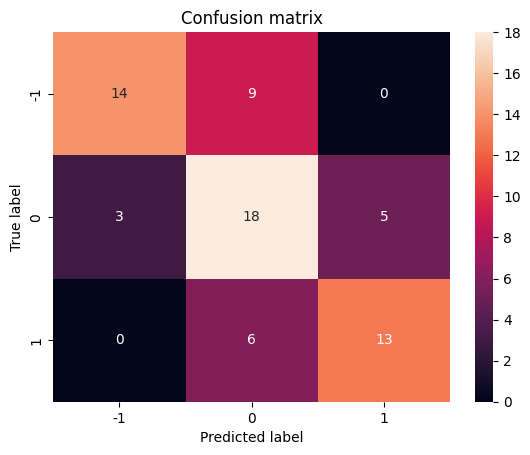

In [14]:
metric, model = calc_metrics(
    # отбираем необходимые признаки
    X.filter(regex=r"(target)|(rate)|(usd)|(inflation)").values,
    y.values,
    RandomForestClassifier,
    name="lag target, rate, usd, inflation Random Forest",
    calc_jobs=-1,
    random_state=42,
)

In [15]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
lag target Random Forest,0.514706,0.523987,0.525172,0.541766,0.729330,0.736446
"lag target, rate Random Forest",0.602941,0.616172,0.604060,0.639683,0.733619,0.740583
"lag target, rate, usd Random Forest",0.573529,0.580662,0.568679,0.628133,0.763321,0.769781
"lag target, rate, usd, inflation Random Forest",0.661765,0.670957,0.661738,0.697069,0.760278,0.764991


Теперь добавим рост каждого показателя(во сколько раз вырос показатель). И добавим лаговые признаки по каждому такому показателю.

In [16]:
for column in ("inflation", "rate", "usd"):
    X[f"growth_{column}"] = X[column] / X[column].shift(1)

In [17]:
for column in X.filter(regex="growth").columns:
    for i in range(1, 5):
        X[f"lag{i}_{column}"] = X[column].shift(i)

              precision    recall  f1-score   support

        -1.0       0.75      0.65      0.70        23
         0.0       0.56      0.69      0.62        26
         1.0       0.81      0.68      0.74        19

    accuracy                           0.68        68
   macro avg       0.71      0.68      0.69        68
weighted avg       0.70      0.68      0.68        68



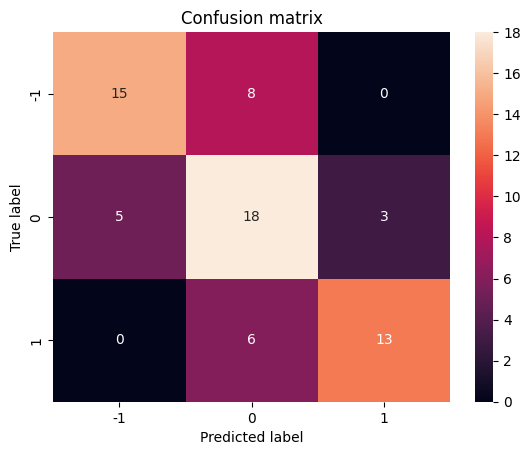

In [18]:
metric, model = calc_metrics(
    # отбираем необходимые признаки
    X.filter(regex=r"(target)|(rate)|(usd)|(inflation)").values,
    y.values,
    RandomForestClassifier,
    name="lag target, rate, usd, inflation, growth Random Forest",
    calc_jobs=-1,
    random_state=42,
)

In [19]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
lag target Random Forest,0.514706,0.523987,0.525172,0.541766,0.729330,0.736446
"lag target, rate Random Forest",0.602941,0.616172,0.604060,0.639683,0.733619,0.740583
"lag target, rate, usd Random Forest",0.573529,0.580662,0.568679,0.628133,0.763321,0.769781
"lag target, rate, usd, inflation Random Forest",0.661765,0.670957,0.661738,0.697069,0.760278,0.764991
"lag target, rate, usd, inflation, growth Random Forest",0.676471,0.687074,0.676231,0.708333,0.778322,0.783129


Попробуем подобрать количество лаговых признаков и гиперпараметры `RandomForestClassifier`

### Random Forest tuning hyperparameters

In [20]:
# удалим все лаговые переменные
X = pd.read_csv("../data/x.csv", index_col="date")

In [21]:
def objective(trial):

    # параметры для перебора
    params = {
        "n_lags": trial.suggest_int("n_lags", 2, 5),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    }

    features = ["inflation", "rate", "usd"]

    # Создаем копию признаков
    data = X[features].copy()

    # добавляем лаги целевой переменной
    for i in range(1, params["n_lags"] + 1):
        data[f"lag{i}_target"] = y.shift(i)

    # для всех экзогенных признаков
    for feature in ["inflation", "rate", "usd"]:
        # добавляем рост
        data[f"growth_{feature}"] = data[feature] / data[feature].shift(1)
        features.append(f"growth_{feature}")

    # для всех признаков добавляем лаги
    for feature in features:
        for i in range(1, params["n_lags"]):
            data[f"lag{i}_{feature}"] = data[feature].shift(i)

    model = RandomForestClassifier(
        max_depth=params["max_depth"],
        min_samples_leaf=params["min_samples_leaf"],
        min_samples_split=params["min_samples_split"],
        random_state=42,
    )

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(data.values, y, model, name=" ", plot=False, calc_jobs=-1)

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300, show_progress_bar=True)

  0%|          | 0/300 [00:00<?, ?it/s]

In [22]:
study.best_params

{'n_lags': 4, 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2}

Посмотрим метрики подробнее

              precision    recall  f1-score   support

        -1.0       0.74      0.61      0.67        23
         0.0       0.56      0.73      0.63        26
         1.0       0.87      0.68      0.76        19

    accuracy                           0.68        68
   macro avg       0.72      0.67      0.69        68
weighted avg       0.71      0.68      0.68        68



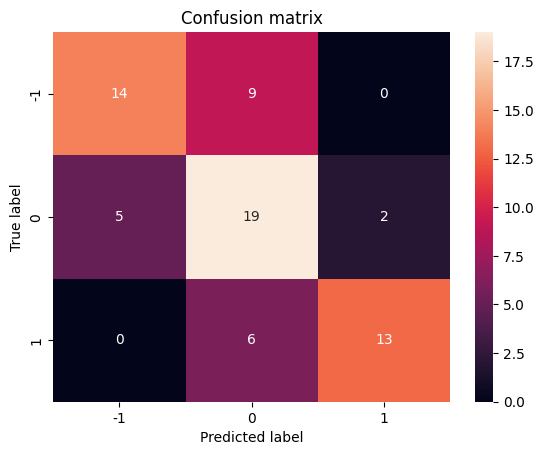

In [23]:
features = ["inflation", "rate", "usd"]

# Создаем копию признаков
data = X[features].copy()

# добавляем лаги целевой переменной
for i in range(1, study.best_params["n_lags"] + 1):
    data[f"lag{i}_target"] = y.shift(i)

# для всех экзогенных признаков
for feature in ["inflation", "rate", "usd"]:
    # добавляем рост
    data[f"growth_{feature}"] = data[feature] / data[feature].shift(1)
    features.append(f"growth_{feature}")

# для всех признаков добавляем лаги
for feature in features:
    for i in range(1, study.best_params["n_lags"]):
        data[f"lag{i}_{feature}"] = data[feature].shift(i)

model = RandomForestClassifier(
    max_depth=study.best_params["max_depth"],
    min_samples_leaf=study.best_params["min_samples_leaf"],
    min_samples_split=study.best_params["min_samples_split"],
    random_state=42,
)

# считаем метрики на кросс валидации
metric, _ = calc_metrics(data.values, y, model, name="TimeSeries way Random Forest", calc_jobs=-1)

In [24]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
lag target Random Forest,0.514706,0.523987,0.525172,0.541766,0.729330,0.736446
"lag target, rate Random Forest",0.602941,0.616172,0.604060,0.639683,0.733619,0.740583
"lag target, rate, usd Random Forest",0.573529,0.580662,0.568679,0.628133,0.763321,0.769781
"lag target, rate, usd, inflation Random Forest",0.661765,0.670957,0.661738,0.697069,0.760278,0.764991
"lag target, rate, usd, inflation, growth Random Forest",0.676471,0.687074,0.676231,0.708333,0.778322,0.783129
TimeSeries way Random Forest,0.676471,0.688235,0.674558,0.720777,0.787730,0.793229


Отлично, мы еще немного улучшили наши метрики. Тем попробуем классификацию по ближайшим соседям.

### KNN tuning hyperparameters

In [25]:
def objective(trial):
    # параметры для перебора
    params = {
        "n_lags": trial.suggest_int("n_lags", 2, 5),
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 25),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "p": trial.suggest_int("p", 1, 2),
    }

    features = ["inflation", "rate", "usd"]

    # Создаем копию признаков
    data = X[features].copy()

    # добавляем лаги целевой переменной
    for i in range(1, params["n_lags"] + 1):
        data[f"lag{i}_target"] = y.shift(i)

    # для всех экзогенных признаков
    for feature in ["inflation", "rate", "usd"]:
        # добавляем рост
        data[f"growth_{feature}"] = data[feature] / data[feature].shift(1)
        features.append(f"growth_{feature}")

    # для всех признаков добавляем лаги
    for feature in features:
        for i in range(1, params["n_lags"]):
            data[f"lag{i}_{feature}"] = data[feature].shift(i)

    model = KNeighborsClassifier(
                params['n_neighbors'], weights=params['weights'], p=params['p'], algorithm='brute',
            )
    
    # заполняем пропуски следующими значениями
    data.bfill(inplace=True)

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(data.values, y, model, name=" ", plot=False, calc_jobs=-1)

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300, show_progress_bar=True, catch=(ValueError,))

  0%|          | 0/300 [00:00<?, ?it/s]

In [26]:
study.best_params

{'n_lags': 4, 'n_neighbors': 2, 'weights': 'distance', 'p': 1}

              precision    recall  f1-score   support

        -1.0       0.81      0.74      0.77        23
         0.0       0.61      0.65      0.63        26
         1.0       0.74      0.74      0.74        19

    accuracy                           0.71        68
   macro avg       0.72      0.71      0.71        68
weighted avg       0.71      0.71      0.71        68



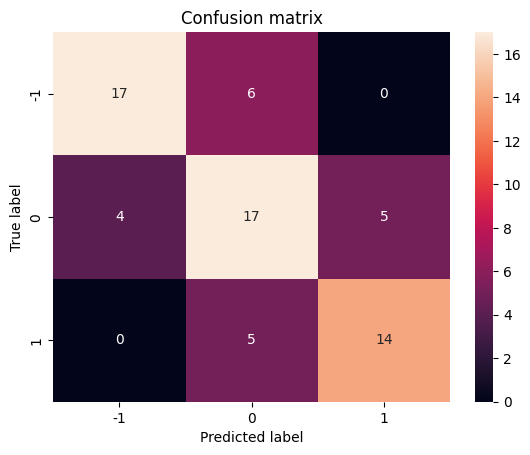

In [27]:
features = ["inflation", "rate", "usd"]

# Создаем копию признаков
data = X[features].copy()

# добавляем лаги целевой переменной
for i in range(1, study.best_params["n_lags"] + 1):
    data[f"lag{i}_target"] = y.shift(i)

# для всех экзогенных признаков
for feature in ["inflation", "rate", "usd"]:
    # добавляем рост
    data[f"growth_{feature}"] = data[feature] / data[feature].shift(1)
    features.append(f"growth_{feature}")

# для всех признаков добавляем лаги
for feature in features:
    for i in range(1, study.best_params["n_lags"]):
        data[f"lag{i}_{feature}"] = data[feature].shift(i)

model = KNeighborsClassifier(
    study.best_params["n_neighbors"],
    weights=study.best_params["weights"],
    p=study.best_params["p"],
    algorithm="brute",
)

# заполняем пропуски следующими значениями
data.bfill(inplace=True)

# считаем метрики на кросс валидации
metric, _ = calc_metrics(data.values, y, model, name="TimeSeries way KNN", plot=True, calc_jobs=-1)

In [28]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
lag target Random Forest,0.514706,0.523987,0.525172,0.541766,0.729330,0.736446
"lag target, rate Random Forest",0.602941,0.616172,0.604060,0.639683,0.733619,0.740583
"lag target, rate, usd Random Forest",0.573529,0.580662,0.568679,0.628133,0.763321,0.769781
"lag target, rate, usd, inflation Random Forest",0.661765,0.670957,0.661738,0.697069,0.760278,0.764991
"lag target, rate, usd, inflation, growth Random Forest",0.676471,0.687074,0.676231,0.708333,0.778322,0.783129
TimeSeries way Random Forest,0.676471,0.688235,0.674558,0.720777,0.787730,0.793229
TimeSeries way KNN,0.705882,0.713066,0.709940,0.717836,0.806009,0.809599


Классификация с помощью k ближайших соседей показала себя получше случайного леса, возможно из-за того что у нас очень мало данных, попробуем бустинг.

### CatBoost tuning hyperparameters

In [33]:
def objective(trial):
    # параметры для перебора
    params = {
        "n_lags": trial.suggest_int("n_lags", 2, 5),
        "depth": trial.suggest_int("depth", 3, 15),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 1e-1),
    }

    features = ["inflation", "rate", "usd"]

    # Создаем копию признаков
    data = X[features].copy()

    # добавляем лаги целевой переменной
    for i in range(1, params["n_lags"] + 1):
        data[f"lag{i}_target"] = y.shift(i)

    # для всех экзогенных признаков
    for feature in ["inflation", "rate", "usd"]:
        # добавляем рост
        data[f"growth_{feature}"] = data[feature] / data[feature].shift(1)
        features.append(f"growth_{feature}")

    # для всех признаков добавляем лаги
    for feature in features:
        for i in range(1, params["n_lags"]):
            data[f"lag{i}_{feature}"] = data[feature].shift(i)

    model = CatBoostClassifier(
        iterations=100,
        depth=params["depth"],
        l2_leaf_reg=params["l2_leaf_reg"],
        random_state=42,
        verbose=False,
        early_stopping_rounds=20
    )

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(data.values, y, model, name=" ", plot=False)

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True, catch=(ValueError,))

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
study.best_params

{'n_lags': 2, 'depth': 3, 'l2_leaf_reg': 0.055465870623472996}

Посотрим на лучшую модель подробнее.

              precision    recall  f1-score   support

        -1.0       0.75      0.52      0.62        23
         0.0       0.47      0.69      0.56        26
         1.0       0.71      0.53      0.61        19

    accuracy                           0.59        68
   macro avg       0.65      0.58      0.59        68
weighted avg       0.63      0.59      0.59        68



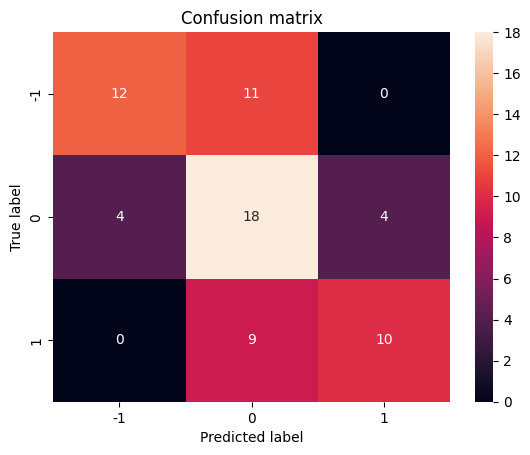

In [35]:
features = ["inflation", "rate", "usd"]

# Создаем копию признаков
data = X[features].copy()

# добавляем лаги целевой переменной
for i in range(1, study.best_params["n_lags"] + 1):
    data[f"lag{i}_target"] = y.shift(i)

# для всех экзогенных признаков
for feature in ["inflation", "rate", "usd"]:
    # добавляем рост
    data[f"growth_{feature}"] = data[feature] / data[feature].shift(1)
    features.append(f"growth_{feature}")

# для всех признаков добавляем лаги
for feature in features:
    for i in range(1, study.best_params["n_lags"]):
        data[f"lag{i}_{feature}"] = data[feature].shift(i)

model = CatBoostClassifier(
    iterations=100,
    depth=study.best_params["depth"],
    l2_leaf_reg=study.best_params["l2_leaf_reg"],
    random_state=42,
    verbose=False,
    early_stopping_rounds=20
)

# считаем метрики на кросс валидации
metric, _ = calc_metrics(data.values, y, model, name="TimeSeries way CatBoost", plot=True)

In [37]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
lag target Random Forest,0.514706,0.523987,0.525172,0.541766,0.729330,0.736446
"lag target, rate Random Forest",0.602941,0.616172,0.604060,0.639683,0.733619,0.740583
"lag target, rate, usd Random Forest",0.573529,0.580662,0.568679,0.628133,0.763321,0.769781
"lag target, rate, usd, inflation Random Forest",0.661765,0.670957,0.661738,0.697069,0.760278,0.764991
"lag target, rate, usd, inflation, growth Random Forest",0.676471,0.687074,0.676231,0.708333,0.778322,0.783129
TimeSeries way Random Forest,0.676471,0.688235,0.674558,0.720777,0.787730,0.793229
TimeSeries way KNN,0.705882,0.713066,0.709940,0.717836,0.806009,0.809599
TimeSeries way CatBoost,0.588235,0.594648,0.580121,0.645990,0.775209,0.781743


Лучше других себя показал метод k ближайших соседей, использовавший лаговые признаки всех переменных в диапазоне от 1 до 3. Проанализировав матрицу ошибок можем сделать вывод, что модель одинаково хорошо детектирует все виды классов, и не разу не перепутала повышение ставки с понижением. В данных нет таких кейсов где за повышением сразу следует понижение ставки и наоборот, в результате чего хоть модель и не показывает очень высокого качества, но и не допускает грубых ошибок(вместо повышения предсказывает понижение и наоборот)